- KEYWORDS: autograd


## Choice of activation functions in neural networks



The activation function in a neural network provides the nonlinearity in the model. We previously learned that one interpretation of the activation function is that it is a basis function that you can expand the data in to find a functional representation that fits the data.

Today we explore the impact of the activation function on the fitting, and extrapolation of neural networks. The following code is for setting up a neural network, and initializing the parameters with random numbers.



In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr

def nn(params, inputs, activation=np.tanh):
    """a neural network.
    params is a list of (weights, bias) for each layer.
    inputs goes into the nn. Each row corresponds to one output label.
    activation is the nonlinear activation function.
    """
    for W, b in params[:-1]:
        outputs = np.dot(inputs, W) + b
        inputs = activation(outputs)
    # no activation on the last layer
    W, b = params[-1]
    return np.dot(inputs, W) + b

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Out [1]:

As before, we are going to consider this dataset so we can evaluate fitting and extrapolation.



# Out [2]:
# text/plain
Text(0, 0.5, 'y')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

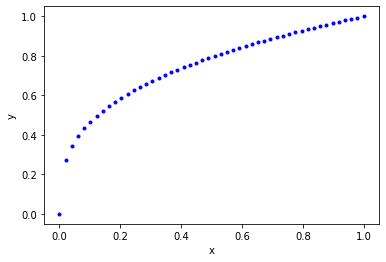

In [1]:
# Some generated data
X = np.linspace(0, 1)
Y = X**(1. / 3.)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(X, Y, 'b.')
plt.xlabel('x')
plt.ylabel('y')

### tanh



First we review the case of `tanh` which is a classic activation function. The `tanh` function is "active" between about &plusmn; 2.5, and outside that window it saturates. That means the derivative of this function becomes close to zero outside that window. So if you have large values of inputs, you should scale them to avoid this issue.



# Out [210]:
# text/plain
Text(0, 0.5, 'y')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

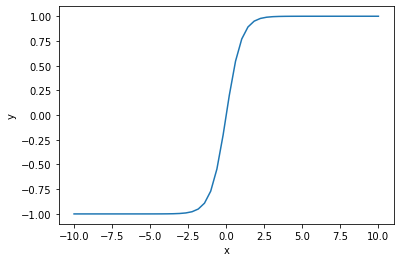

In [1]:
xt = np.linspace(-10, 10)
plt.plot(xt, np.tanh(xt))
plt.xlabel('x')
plt.ylabel('y')

In [1]:
def objective1(params, step=None):
    pred = nn(params, np.array([X]).T)
    err = np.array([Y]).T - pred
    return np.mean(err**2)

from autograd.misc.optimizers import adam
from autograd import grad

params1 = init_random_params(0.1, layer_sizes=[1, 3, 1])

N = 50
MAX_EPOCHS = 500

for i in range(MAX_EPOCHS):
    params1 = adam(grad(objective1), params1,
                  step_size=0.01, num_iters=N)
    if i % 100 == 0:  # print every 100th step
        print(f'Step {i}: {objective1(params1)}')
    if objective(params1, _) < 2e-5:
        print('Tolerance reached, stopping')
        break

# Out [256]:
# output
Step 0: 0.023475979216618596
Step 100: 0.00012554551763604006
Step 200: 7.263614679620085e-05
Tolerance reached, stopping

Now we can examine the fit and extrapolation.



# Out [257]:
# output
/Users/jkitchin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

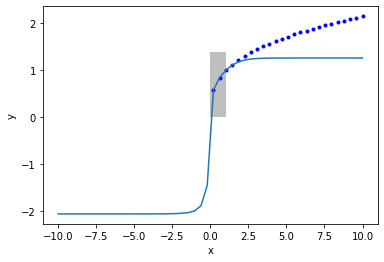

In [1]:
X2 = np.linspace(-10, 10)
Y2 = X2**(1/3)
Z2 = nn(params1, X2.reshape([-1, 1]))

plt.plot(X2, Y2, 'b.', label='analytical')
plt.plot(X2, Z2, label='NN')
plt.fill_between(X2 < 1, 0, 1.4, facecolor='gray', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y');

For large enough $x$, all of the `tanh` functions saturate at $y=1$. So, the neural network also saturates at a constant value for large $x$.

**exercise** Can you work out from the NN math what the saturated values should be?



### relu



A common activation function in deep learning is the Relu:



# Out [258]:
# text/plain

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

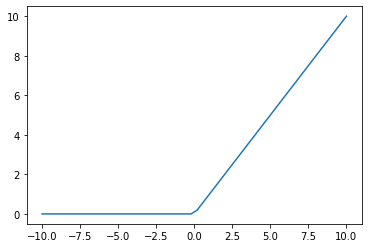

In [1]:
def relu(x):
    return x * (x > 0)

plt.plot(X2, relu(X2))

This is popular because if is very fast to compute, and the derivatives are constant. For positive $x$ there is no saturation. For negative $x$, however, the neuron is "dead".



In [1]:
def objective2(par, step=None):
    pred = nn(par, np.array([X]).T, activation=relu)
    err = np.array([Y]).T - pred
    return np.mean(err**2)

from autograd.misc.optimizers import adam
from autograd import grad

params2 = init_random_params(0.01, layer_sizes=[1, 3, 1])

N = 50
MAX_EPOCHS = 500

for i in range(MAX_EPOCHS):
    params2 = adam(grad(objective2), params2,
                  step_size=0.01, num_iters=N)
    if i % 100 == 0:  # print every 100th step
        print(f'Step {i}: {objective2(params2)}')
    if objective(params2, _) < 2e-5:
        print('Tolerance reached, stopping')
        break

# Out [263]:
# output
Step 0: 0.02191181276983396
Step 100: 0.005827380130793075
Step 200: 0.005827378655405296
Step 300: 0.005827381200541291
Step 400: 0.005827413151700692

# Out [264]:
# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

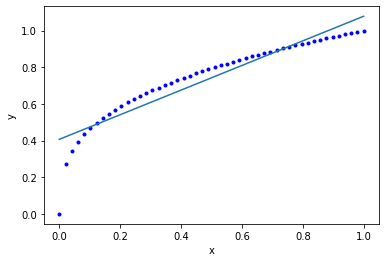

In [1]:
X2 = np.linspace(0., 1)
Y2 = X2**(1/3)
Z2 = nn(params2, X2.reshape([-1, 1]), activation=relu)

plt.plot(X2, Y2, 'b.', label='analytical')
plt.plot(X2, Z2, label='NN')
plt.xlabel('x')
plt.ylabel('y');

In [1]:
params2

# Out [265]:
# text/plain
[(array([[ 0.00274516, -0.00890915,  1.18630882]]),
  array([-0.00312292, -0.00157667,  0.00963592])),
 (array([[-0.007047  ],
         [ 0.00943261],
         [ 0.56577239]]), array([0.40114379]))]

Notes:

1.  The fit is not very good.
2.  we have piecewise linear fits here.
3.  There are negative weights, which means there are some "dead neurons". Maybe other initial guesses might improve this.

Let's look at the extrapolating behavior.



# Out [278]:
# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

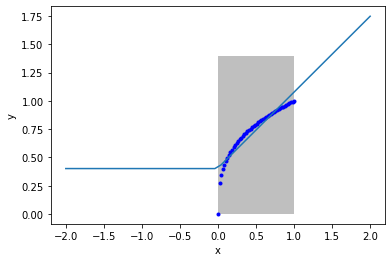

In [1]:
X2 = np.linspace(0, 1)
Y2 = X2**(1/3)

xf = np.linspace(-2, 2)
Z2 = nn(params2, xf.reshape([-1, 1]), activation=relu)

plt.plot(X2, Y2, 'b.', label='analytical')
plt.plot(xf, Z2, label='NN')
plt.fill_between(X2 < 1, 0, 1.4, facecolor='gray', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y');

Notes this extrapolates linearly on the right, and is constant on the left. These are properties of the Relu.



### Gaussian (radial basis function)



Finally we consider the Gaussian activation function.



# Out [279]:
# text/plain

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

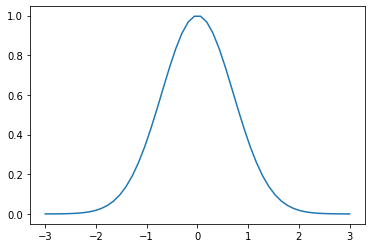

In [1]:
def rbf(x):
    return np.exp(-x**2)

x3 = np.linspace(-3, 3)
plt.plot(x3, rbf(x3))

Now we fit the data.



In [1]:
def objective3(pars, step=None):
    pred = nn(pars, np.array([X]).T, activation=rbf)
    err = np.array([Y]).T - pred
    return np.mean(err**2)

from autograd.misc.optimizers import adam
from autograd import grad

params3 = init_random_params(0.1, layer_sizes=[1, 3, 1])

N = 50
MAX_EPOCHS = 500

for i in range(MAX_EPOCHS):
    params3 = adam(grad(objective3), params3,
                  step_size=0.01, num_iters=N)
    if i % 100 == 0:  # print every 100th step
        print(f'Step {i}: {objective3(params3)}')
    if objective(params, _) < 2e-5:
        print('Tolerance reached, stopping')
        break

# Out [285]:
# output
Step 0: 0.048947502405824884
Step 100: 0.001155249752025019
Step 200: 0.0011110034206499504
Step 300: 0.001055630320237095
Step 400: 0.0010076441261250328

# Out [287]:
# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

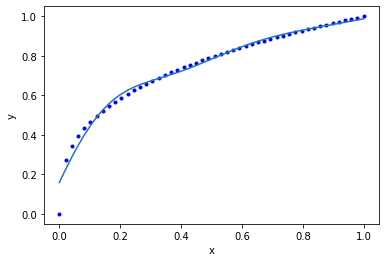

In [1]:
X2 = np.linspace(0., 1)
Y2 = X2**(1/3)
Z2 = nn(params3, X2.reshape([-1, 1]), activation=rbf)

plt.plot(X2, Y2, 'b.', label='analytical')
plt.plot(X2, Z2, label='NN')
plt.xlabel('x')
plt.ylabel('y');

Note we have piecewise linear fits here.



# Out [291]:
# output
/Users/jkitchin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

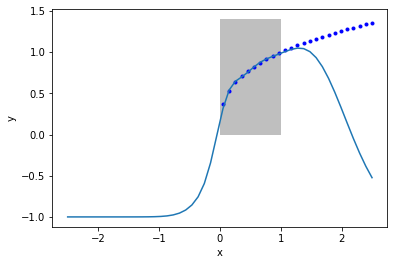

In [1]:
X2 = np.linspace(-2.5, 2.5)
Y2 = X2**(1/3)
Z2 = nn(params3, X2.reshape([-1, 1]), activation=rbf)

plt.plot(X2, Y2, 'b.', label='analytical')
plt.plot(X2, Z2, label='NN')
plt.fill_between(X2 < 1, 0, 1.4, facecolor='gray', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y');

Notes this extrapolates to zero when you are far from the data. It fits reasonably in the region trained. "If your function is nonlinear enough, somewhere the nonlinearity matches your data." (Z. Ulissi).



### Summary



We can think of single layer neural networks as partial expansions in the activation function space. That means the extrapolation behavior will be like the dominating feature of the activation functions, e.g. relu extrapolates like a line, tanh saturates at large x, and Gaussians effectively go to zero. Unexpected things can happen at the edges of the data, so at intermediate extrapolations you do not always know what will happen.



## Train/test splits on data



So far we have not considered how to split your data when fitting. This becomes important for a few reasons:

1.  We need to be able to tell if we are overfitting. One way to do this is to compare fitting errors to prediction errors.

This means we need a way to split a dataset into a train set and a test set. Then, we can do training on the train set, and testing on the test set.

Let's start by remembering what our dataset is.



In [1]:
X = np.linspace(0, 1)
Y2 = X**(1/3)

# Out [321]:

The way to split this is that we use indexing. We start by making an array of integers.



In [1]:
ind = np.arange(len(X))
ind

# Out [322]:
# text/plain
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

Next, we randomly shuffle the array of integers.



In [1]:
pind = np.random.permutation(ind)
pind

# Out [323]:
# text/plain
array([13, 16, 27, 28, 15, 36, 37, 34, 20,  9, 48,  4,  5, 21, 26, 11, 18,
       49, 24, 32, 31,  2, 29, 45, 41, 42, 43, 23, 39, 30, 25, 12, 47,  8,
       40, 44, 10,  7, 46, 33, 17,  1, 22,  3,  0, 19,  6, 38, 35, 14])

Next, we decide on the train/test split. A common choice is 80/20. We find the integer that is closest to 80% of the index array.



In [1]:
split = int(0.8 * len(pind))
split

# Out [324]:
# text/plain
40

In [1]:
train_ind = pind[:split]
test_ind = pind[split:]
(len(train_ind), len(test_ind))

# Out [325]:
# text/plain
(40, 10)

We check that we have a reasonable choice here.



# Out [327]:
# text/plain

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

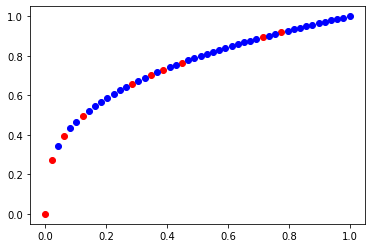

In [1]:
train_x = X[train_ind]
train_y = Y2[train_ind]

test_x = X[test_ind]
test_y = Y2[test_ind]
plt.plot(test_x, test_y, 'ro')
plt.plot(train_x, train_y, 'bo')

Now, we train on the train data.



In [1]:
def objective10(params, step=None):
    pred = nn(params, np.array([train_x]).T)
    err = np.array([train_y]).T - pred
    return np.mean(err**2)

from autograd.misc.optimizers import adam
from autograd import grad

params10 = init_random_params(0.1, layer_sizes=[1, 3, 1])

N = 50
MAX_EPOCHS = 500

for i in range(MAX_EPOCHS):
    params10 = adam(grad(objective10), params10,
                  step_size=0.01, num_iters=N)
    if i % 100 == 0:  # print every 100th step
        print(f'Step {i}: {objective10(params10)}')
    if objective(params1, _) < 2e-5:
        print('Tolerance reached, stopping')
        break

# Out [329]:
# output
Step 0: 0.010888721129733877
Step 100: 1.2229318716118184e-05
Step 200: 4.576676771933132e-06
Step 300: 4.507138411909511e-06
Step 400: 5.368591062801168e-06

As usual, we should check the fit on the train data. This is a little trickier than before, because the points are out of order.



# Out [340]:
# text/plain

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

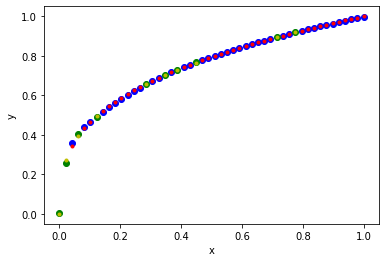

In [1]:
Z2 = nn(params1, train_x.reshape([-1, 1]))
plt.plot(train_x, Z2, 'bo', label='NN')
plt.plot(train_x, train_y, 'r.', label='analytical')
plt.xlabel('x')
plt.ylabel('y')

plt.plot(test_x, nn(params1, test_x.reshape([-1, 1])), 'go', label='NN')
plt.plot(test_x, test_y, 'y.', label='analytical')

In [1]:
rmse_train = np.mean((train_y - nn(params1, train_x.reshape([-1, 1]))**2))
rmse_test =  np.mean((test_y - nn(params1, test_x.reshape([-1, 1]))**2))

print(f'''RMSE train = {rmse_train:1.3f}
RMSE test = {rmse_test:1.3f}''')

# Out [338]:
# output
RMSE train = 0.142
RMSE test = 0.167

Here, the test RMSE is *a little higher* than the train data. This suggests a possible overfitting, but not by much. This may also be due to extrapolation errors because the first two test points are technically outside the training data. For the train/test split to be meaningful, it is important that the two datasets have similar distributions of values.



## Summary



Today we reviewed the role of activation functions in neural networks, and observed that it doesn't generally matter what you use (but the details always matter in individual cases). The mathematical form of these activation functions determines how they will extrapolate, which can be important depending on your application.

We then explored how to efficiently split a dataset into a train and test set so that overfitting can be evaluated. This becomes increasingly important for when you plan to explore many models (choices of hyperparameters), and then you split the data three ways (train, test and validate).

